In [1]:
# Import libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench.util import ema_logging, utilities

plt.style.use('ggplot')
from matplotlib.pyplot import figure
import math

C:\Users\marce\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
results = utilities.load_results('results/Scenarios11000Policy.csv')
experiments, outcomes = results

outcomes_splitted = {'evac100': [], 'evac95': [], 'evac75': [], 'evac50': [], 'mean_delay': [], 'min_delay': [], 'max_delay': [], 'mean_density': [], 'mean_walkspeed': [], 'exit1': [], 'exit2': [], 'exit3': [], 'exit4': [], 'exit5': []}

for outcome in outcomes["evactimes"]:
    outcomes_splitted['evac100'].append(outcome[0][0])
    outcomes_splitted['evac95'].append(outcome[0][1])
    outcomes_splitted['evac75'].append(outcome[0][2])
    outcomes_splitted['evac50'].append(outcome[0][3])
    
for outcome in outcomes["densities"]:
    outcomes_splitted['mean_delay'].append(outcome[0][0])
    outcomes_splitted['min_delay'].append(outcome[0][1])
    outcomes_splitted['max_delay'].append(outcome[0][2])
    outcomes_splitted['mean_density'].append(outcome[0][3])
    outcomes_splitted['mean_walkspeed'].append(outcome[0][4])
    
for outcome in outcomes["evacuees_per_exit"]:
    outcomes_splitted['exit1'].append(outcome[0][0])
    outcomes_splitted['exit2'].append(outcome[0][1])
    outcomes_splitted['exit3'].append(outcome[0][2])
    outcomes_splitted['exit4'].append(outcome[0][3])
    outcomes_splitted['exit5'].append(outcome[0][4])
    
df_outcomes = pd.DataFrame(outcomes_splitted)
df = pd.concat([experiments,df_outcomes],axis=1,sort=False)

# Using DataFrame.drop
df.drop(df.columns[3:11], axis=1, inplace=True)

In [4]:
df.nsmallest(5, "evac100")

,compliance,familiarity,population,policy,model,evac100,evac95,evac75,evac50,mean_delay,min_delay,max_delay,mean_density,mean_walkspeed,exit1,exit2,exit3,exit4,exit5
13833,0.9,1.00,700,Wider Both,evacuation,136.0,119.0,84.0,55.0,11.201375,2.0,28.0,0.129397,0.598311,73.0,149.0,122.0,261.0,95.0
15316,0.4,1.00,700,Wider Both,evacuation,137.0,115.0,85.0,53.0,11.169458,2.0,27.0,0.127725,0.617165,71.0,153.0,127.0,275.0,74.0
15075,0.4,0.75,700,Wider Both,evacuation,138.0,122.0,86.0,58.0,11.124629,2.0,24.0,0.123325,0.668538,61.0,111.0,117.0,349.0,62.0
10606,0.9,0.75,700,Wider Stairs,evacuation,140.0,124.0,90.0,62.0,11.910979,2.0,27.0,0.135407,0.636446,44.0,108.0,100.0,388.0,60.0
13271,0.4,0.75,700,Wider Both,evacuation,140.0,119.0,85.0,55.0,11.419840,2.0,25.0,0.120962,0.668870,41.0,114.0,110.0,368.0,67.0


In [5]:
def check_convergence(df, crowd, familiarity, compliance, policy):
    df_conv = df[(df['compliance'] == compliance) & (df['familiarity'] == familiarity) & (df['population'] == crowd) & (df['policy'] == policy)]
    
    for index, row in df_conv.iterrows():
        df_conv.loc[index,'Average Ticks'] = df_conv.loc[:index,'evac100'].mean()
        
    df_conv.reset_index(inplace=True)
    
    ax = sns.lineplot(data=df_conv, x=df_conv.index,y='Average Ticks')
    ax.set(xlabel='Number of repetitions',ylabel='Average evacuation time (ticks)')
    plt.show()

In [6]:
#check_convergence(df, 1400, 0.75, 0.65, "Staff")
#check_convergence(df, 1400, 0.50, 0.9, "Staff")

## OVERVIEW ##

In [7]:
table = pd.DataFrame()

table = table.append(df.groupby(['policy']).mean()["evac100"])
table = table.append(df.groupby(['policy']).min()["evac100"])
table = table.append(df.groupby(['policy']).max()["evac100"])
table = table.append(df.groupby(['policy']).std()["evac100"])

table = table.round(0).astype('int32').T
table.columns = ["Mean", "Min", "Max", "STD"]
table.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  Mean &  Min &  Max &  STD \\\\\n\\midrule\nBase            &   340 &  147 &  618 &  125 \\\\\nDynamic Signs   &   305 &  142 &  537 &  110 \\\\\nObstacles       &   328 &  148 &  591 &  118 \\\\\nOne Way Traffic &   349 &  151 &  631 &  129 \\\\\nPhased          &   348 &  168 &  618 &  119 \\\\\nStaff           &   323 &  181 &  559 &   97 \\\\\nWider Both      &   306 &  136 &  591 &  113 \\\\\nWider Exit      &   320 &  146 &  623 &  120 \\\\\nWider Stairs    &   326 &  140 &  607 &  117 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [8]:
table

,Mean,Min,Max,STD
Base,340,147,618,125
Dynamic Signs,305,142,537,110
Obstacles,328,148,591,118
One Way Traffic,349,151,631,129
Phased,348,168,618,119
Staff,323,181,559,97
Wider Both,306,136,591,113
Wider Exit,320,146,623,120
Wider Stairs,326,140,607,117


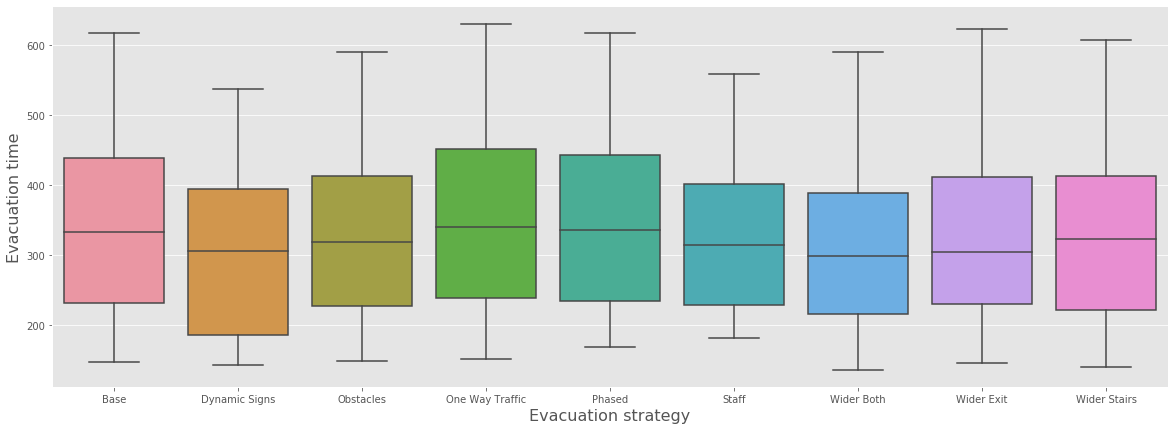

In [51]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(x="policy", y="evac100", data=df)

plt.xlabel('Evacuation strategy', fontsize=16)
plt.ylabel('Evacuation time', fontsize=16)
fig.savefig('overview-strategies-saved.jpg')

## OVERVIEW POPULATION ##

In [38]:
for index, row in df.iterrows():
    if row['population'] == 700:
        df.loc[index,'Density'] = "Low"
    elif row['population'] == 1400:
        df.loc[index,'Density'] = "Medium"
    elif row['population'] == 2100:
        df.loc[index,'Density'] = "High"

In [42]:
df = df.iloc[1:]


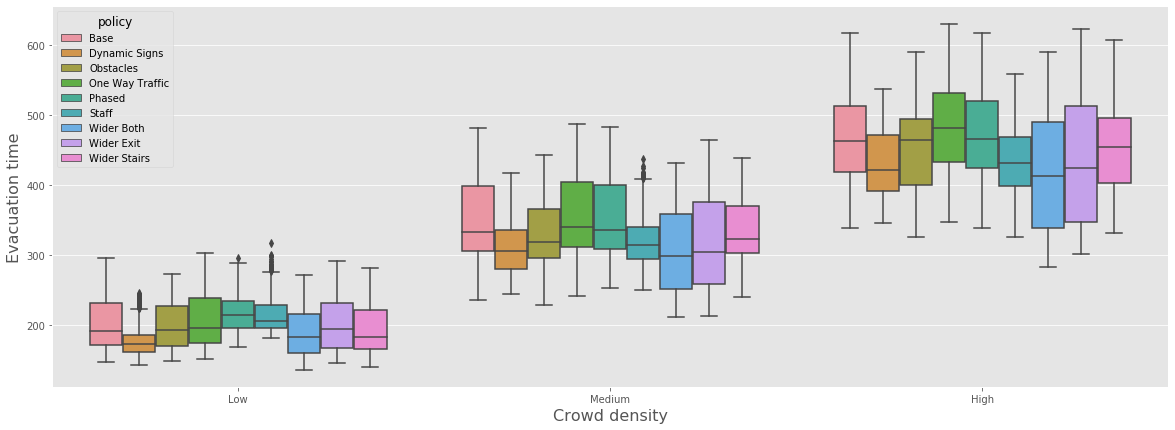

In [49]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(x="Density", y="evac100", hue="policy", data=df)

plt.xlabel('Crowd density', fontsize=16)
plt.ylabel('Evacuation time', fontsize=16)
fig.savefig('overview-crowddensity-population-saved.jpg')

In [11]:
table = pd.DataFrame()

In [12]:
table["Policy"] = df.groupby(['population','policy']).mean()["evac100"].reset_index()["policy"]
table["Mean"] = df.groupby(['population','policy']).mean()["evac100"].reset_index()["evac100"]
table["Min"] = df.groupby(['population','policy']).min()["evac100"].reset_index()["evac100"]
table["Max"] = df.groupby(['population','policy']).max()["evac100"].reset_index()["evac100"]
table["Std"] = df.groupby(['population','policy']).std()["evac100"].reset_index()["evac100"]

In [13]:
table

,Policy,Mean,Min,Max,Std
0,Base,202.031852,147.0,296.0,36.318556
1,Dynamic Signs,175.745926,142.0,245.0,19.791647
2,Obstacles,200.435556,148.0,273.0,33.508990
3,One Way Traffic,207.239259,151.0,302.0,38.296217
4,Phased,218.179259,168.0,295.0,26.425113
5,Staff,214.117037,181.0,317.0,23.893163
6,Wider Both,189.071852,136.0,271.0,31.758984
7,Wider Exit,200.888889,146.0,291.0,35.828242
8,Wider Stairs,193.242963,140.0,281.0,33.568516
9,Base,349.396296,235.0,481.0,61.536160


In [ ]:
#df700 = df[df["population"] == 700]
#df700["population"] = df700['population'].cat.remove_categories([1400,2100])

#df1400 = df[df["population"] == 1400]
#df1400["population"] = df1400['population'].cat.remove_categories([700,2100])

# df2100 = df[df["population"] == 2100]
# df2100["population"] = df2100['population'].cat.remove_categories([700,1400])

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# sns.boxplot(ax = axs[0], x="population", y="evac100", hue="policy", data=df700)
# sns.boxplot(ax = axs[1], x="population", y="evac100", hue="policy", data=df1400)
# sns.boxplot(ax = axs[2], x="population", y="evac100", hue="policy", data=df2100)
# axs[0].legend(loc=1)
# axs[1].legend(loc=1)
# axs[2].legend(loc=1)

# fig.suptitle('Exploration of results')
# #axs[0].set_title("Small building")
# #axs[1].set_title("Big building")

In [33]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
# sns.boxplot(ax = axs[0], x="population", y="evac95", hue="policy", data=df700)
# sns.boxplot(ax = axs[1], x="population", y="evac95", hue="policy", data=df1400)
# sns.boxplot(ax = axs[2], x="population", y="evac95", hue="policy", data=df2100)

# fig.suptitle('Exploration of results')

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
# sns.boxplot(ax = axs[0], x="population", y="mean_density", hue="policy", data=df700)
# sns.boxplot(ax = axs[1], x="population", y="mean_density", hue="policy", data=df1400)
# sns.boxplot(ax = axs[2], x="population", y="mean_density", hue="policy", data=df2100)

# fig.suptitle('Exploration of results')

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
# sns.boxplot(ax = axs[0], x="population", y="mean_walkspeed", hue="policy", data=df700)
# sns.boxplot(ax = axs[1], x="population", y="mean_walkspeed", hue="policy", data=df1400)
# sns.boxplot(ax = axs[2], x="population", y="mean_walkspeed", hue="policy", data=df2100)

# fig.suptitle('Exploration of results')

In [34]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
# sns.boxplot(ax = axs[0], x="population", y="mean_delay", hue="policy", data=df700)
# sns.boxplot(ax = axs[1], x="population", y="mean_delay", hue="policy", data=df1400)
# sns.boxplot(ax = axs[2], x="population", y="mean_delay", hue="policy", data=df2100)

# fig.suptitle('Exploration of results')

## OVERVIEW FAMILIARITY ##

In [14]:
df_fam0 = df[df["familiarity"] == 0.00]
df_fam0["familiarity"] = df_fam0['familiarity'].cat.remove_categories([0.25,0.50,0.75,1.00])

df_fam25 = df[df["familiarity"] == 0.25]
df_fam25["familiarity"] = df_fam25['familiarity'].cat.remove_categories([0.00,0.50,0.75,1.00])

df_fam50 = df[df["familiarity"] == 0.50]
df_fam50["familiarity"] = df_fam50['familiarity'].cat.remove_categories([0.00,0.25,0.75,1.00])

df_fam75 = df[df["familiarity"] == 0.75]
df_fam75["familiarity"] = df_fam75['familiarity'].cat.remove_categories([0.00,0.25,0.50,1.00])

df_fam100 = df[df["familiarity"] == 1.00]
df_fam100["familiarity"] = df_fam100['familiarity'].cat.remove_categories([0.00,0.25,0.50,0.75])

C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

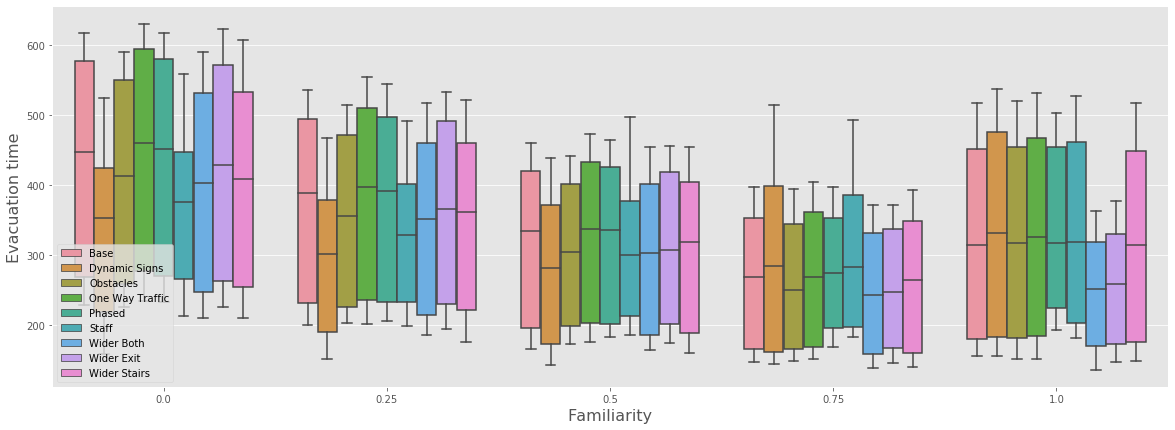

In [50]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(x="familiarity", y="evac100", hue="policy", data=df)
plt.legend(loc=3)
plt.xlabel('Familiarity', fontsize=16)
plt.ylabel('Evacuation time', fontsize=16)
fig.savefig('overview-familiarity-strategies-saved.jpg')

In [16]:
# fig, axs = plt.subplots(1, 5, figsize=(15, 10), sharey=True)
# sns.boxplot(ax = axs[0], x="familiarity", y="evac100", hue="policy", data=df_fam0)
# sns.boxplot(ax = axs[1], x="familiarity", y="evac100", hue="policy", data=df_fam25)
# sns.boxplot(ax = axs[2], x="familiarity", y="evac100", hue="policy", data=df_fam50)
# sns.boxplot(ax = axs[3], x="familiarity", y="evac100", hue="policy", data=df_fam75)
# sns.boxplot(ax = axs[4], x="familiarity", y="evac100", hue="policy", data=df_fam100)
# axs[0].legend(loc=1)
# axs[1].legend(loc=1)
# axs[2].legend(loc=1)
# axs[3].legend(loc=1)
# axs[4].legend(loc=1)


# fig.suptitle('Exploration of results')
# #axs[0].set_title("Small building")
# #axs[1].set_title("Big building")

In [17]:
df_exitnumbers = df.groupby(["familiarity"]).mean()
df_exitnumbers.drop(df_exitnumbers.columns[0:9], axis=1, inplace=True)

In [18]:
df_exitnumbers.astype('int32')

,exit1,exit2,exit3,exit4,exit5
familiarity,,,,,
0.0,3,32,28,1350,10
0.25,35,94,94,1096,48
0.5,70,161,166,924,90
0.75,102,221,232,702,127
1.0,137,288,305,503,169


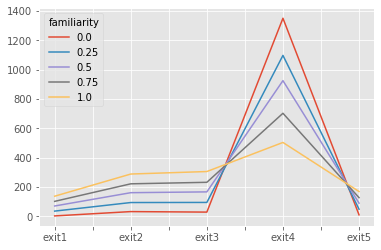

In [54]:
df_exitnumbers.T.plot()


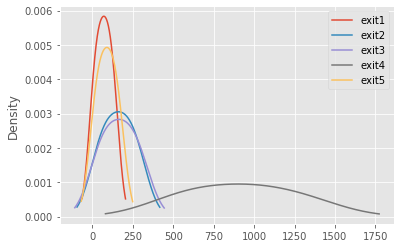

In [20]:
df_exitnumbers.plot(kind='kde')

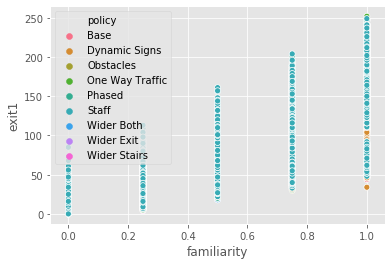

In [21]:
sns.scatterplot(x="familiarity", y="exit1", hue="policy", data=df)

## STRATEGIES ##

### GUIDING STRATEGIES ###

In [58]:
df

,compliance,familiarity,population,policy,model,evac100,evac95,evac75,evac50,mean_delay,min_delay,max_delay,mean_density,mean_walkspeed,exit1,exit2,exit3,exit4,exit5,Density
1,0.90,1.00,700,Base,evacuation,165.0,143.0,97.0,63.0,13.017425,2.0,54.0,0.191612,0.561703,72.0,152.0,132.0,274.0,70.0,Low
2,0.40,0.25,1400,Base,evacuation,398.0,323.0,196.0,119.0,19.073829,2.0,184.0,0.224505,0.360335,38.0,75.0,83.0,1186.0,18.0,Medium
3,0.90,0.00,2100,Base,evacuation,585.0,493.0,332.0,214.0,29.330048,2.0,329.0,0.366072,0.230404,0.0,0.0,0.0,2100.0,0.0,High
4,0.90,0.25,700,Base,evacuation,234.0,201.0,133.0,86.0,13.238946,2.0,53.0,0.130749,0.575873,16.0,40.0,34.0,589.0,21.0,Low
5,0.40,0.25,1400,Base,evacuation,392.0,322.0,190.0,115.0,17.943487,3.0,165.0,0.206659,0.371319,34.0,63.0,80.0,1177.0,46.0,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36445,0.40,0.00,2100,Staff,evacuation,470.0,386.0,249.0,169.0,24.000322,3.0,255.0,0.368129,0.287382,0.0,150.0,149.0,1699.0,102.0,High
36446,0.40,0.75,1400,Staff,evacuation,282.0,243.0,159.0,95.0,20.562768,2.0,171.0,0.372368,0.385329,93.0,255.0,262.0,668.0,122.0,Medium
36447,0.40,0.00,2100,Staff,evacuation,522.0,428.0,274.0,183.0,25.099744,2.0,275.0,0.349069,0.265988,0.0,109.0,69.0,1841.0,81.0,High
36448,0.65,0.50,700,Staff,evacuation,202.0,149.0,112.0,72.0,11.588619,2.0,36.0,0.137466,0.651899,37.0,91.0,103.0,414.0,55.0,Low


In [59]:
df_guiding = df[(df["policy"] == "Base") | (df["policy"] == "Dynamic Signs") | (df["policy"] == "Staff") | (df["policy"] == "One Way Traffic") | (df["policy"] == "Phased")]
#df_guiding = df[(df["policy"] == "Base") | (df["policy"] == "Dynamic Signs") | (df["policy"] == "Staff") | (df["policy"] == "One Way Traffic") | (df["policy"] == "Phased")]

df_guiding["policy"].cat.remove_unused_categories(inplace=True)

C:\Users\marce\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


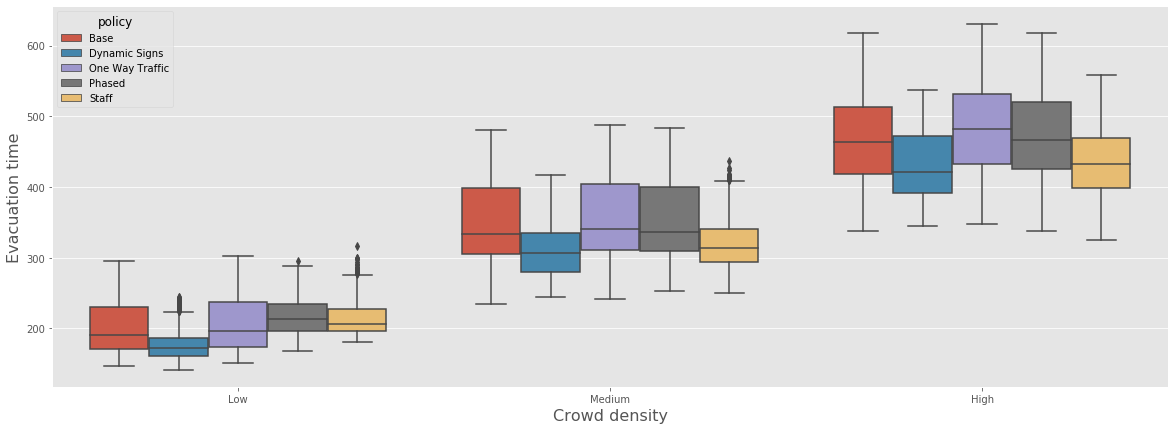

In [61]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(data=df_guiding, x = "Density", y = "evac100", hue="policy")
plt.xlabel('Crowd density', fontsize=16)
plt.ylabel('Evacuation time', fontsize=16)
fig.savefig('overview-guiding-strategies-saved.jpg')

#### COMPLIANCE ####

C:\Users\marce\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\Users\marce\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


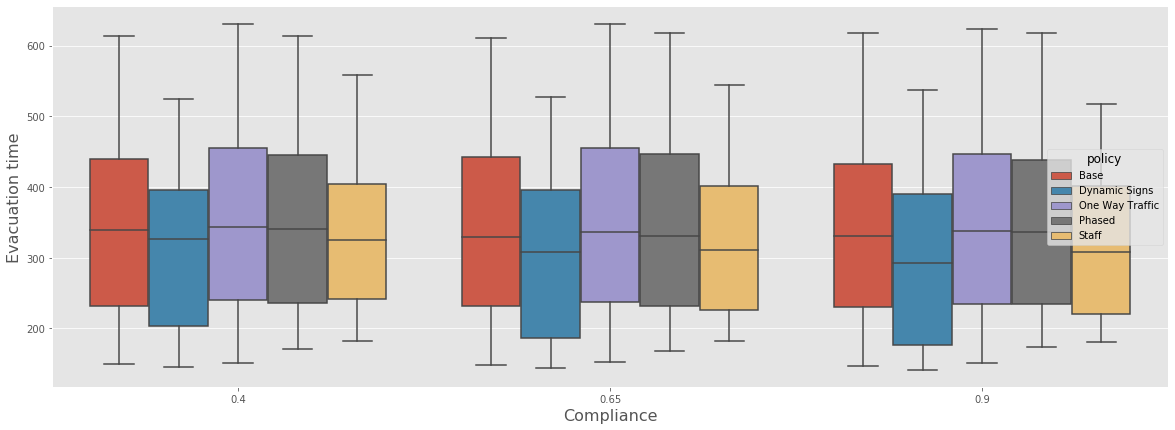

In [63]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(data=df_guiding, x = "compliance", y = "evac100", hue="policy")
plt.xlabel('Compliance', fontsize=16)
plt.ylabel('Evacuation time', fontsize=16)
fig.savefig('overview-guiding-strategies-compliance-saved.jpg')

#### FAMILIARITY ####

C:\Users\marce\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\Users\marce\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


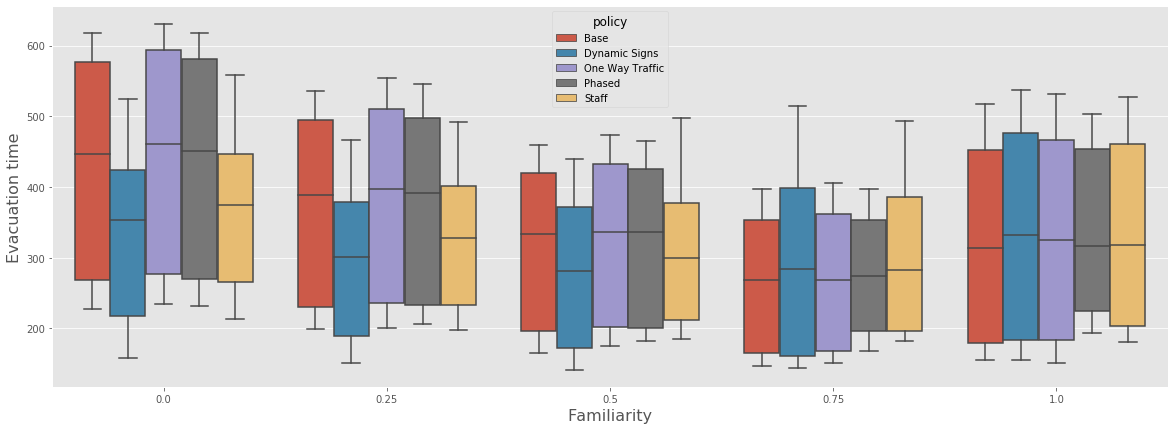

In [64]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(data=df_guiding, x = "familiarity", y = "evac100", hue="policy")
plt.xlabel('Familiarity', fontsize=16)
plt.ylabel('Evacuation time', fontsize=16)
fig.savefig('overview-guiding-strategies-familiarity-saved.jpg')

In [26]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
# sns.swarmplot(ax=axs[0], data=df700[df700["policy"] == "Dynamic Signs"], x="familiarity", y="evac100", hue="compliance")
# sns.swarmplot(ax=axs[1], data=df1400[df1400["policy"] == "Dynamic Signs"], x="familiarity", y="evac100", hue="compliance")
# sns.swarmplot(ax=axs[2], data=df2100[df2100["policy"] == "Dynamic Signs"], x="familiarity", y="evac100", hue="compliance")

In [27]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
# sns.swarmplot(ax=axs[0], data=df700[df700["policy"] == "Dynamic Signs"], x="familiarity", y="evac100", hue="compliance")
# sns.swarmplot(ax=axs[1], data=df1400[df1400["policy"] == "Dynamic Signs"], x="familiarity", y="evac100", hue="compliance")
# sns.swarmplot(ax=axs[2], data=df2100[df2100["policy"] == "Dynamic Signs"], x="familiarity", y="evac100", hue="compliance")

### THROUGHPUT STRATEGIES ###

In [65]:
df.groupby("policy").mean()

,evac100,evac95,evac75,evac50,mean_delay,min_delay,max_delay,mean_density,mean_walkspeed,exit1,exit2,exit3,exit4,exit5
policy,,,,,,,,,,,,,,
Base,340.048654,286.104223,180.976043,114.281798,20.318908,2.252902,172.996048,0.302082,0.405892,69.562608,143.156335,149.719684,955.190170,82.196839
Dynamic Signs,305.232099,256.004444,167.668395,105.629877,21.028735,2.200988,174.840247,0.349786,0.430746,72.277037,230.103210,220.108642,775.750617,101.758025
Obstacles,327.541481,279.848395,177.541975,113.215556,24.813760,2.189136,187.137778,0.256957,0.412859,68.073086,142.366667,150.469383,957.852099,81.236790
One Way Traffic,349.199259,293.382716,186.346173,117.632840,19.644391,2.232593,164.143704,0.288746,0.403311,72.853580,139.489136,156.555309,944.952099,86.148889
Phased,347.704938,293.751605,185.390370,115.687654,18.374350,2.259753,152.548889,0.265344,0.430278,69.441235,142.638765,149.950370,955.609383,82.357778
Staff,323.063210,263.711111,173.139753,108.640247,20.094078,2.258519,163.389877,0.319677,0.425377,72.780988,211.023457,211.530370,782.681235,121.742222
Wider Both,306.136049,250.482963,156.470617,98.621235,18.135650,2.202716,128.423457,0.186945,0.439130,66.800741,142.716296,151.488395,956.525926,82.467407
Wider Exit,320.391358,265.315802,164.184938,100.940988,16.262058,2.168889,134.070617,0.224616,0.434471,68.321235,143.820247,151.448395,953.788889,82.621235
Wider Stairs,326.006914,273.025185,175.630123,112.901481,22.593112,2.284938,165.286420,0.242667,0.406282,68.104198,141.538765,149.765926,958.792593,81.795309


In [66]:
df_flow = df[(df["policy"] == "Base") | (df["policy"] == "Obstacles") | (df["policy"] == "Wider Stairs") | (df["policy"] == "Wider Exit") | (df["policy"] == "Wider Both")]
#df_guiding = df[(df["policy"] == "Base") | (df["policy"] == "Dynamic Signs") | (df["policy"] == "Staff") | (df["policy"] == "One Way Traffic") | (df["policy"] == "Phased")]

df_flow["policy"].cat.remove_unused_categories(inplace=True)

C:\Users\marce\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


#### Population ####

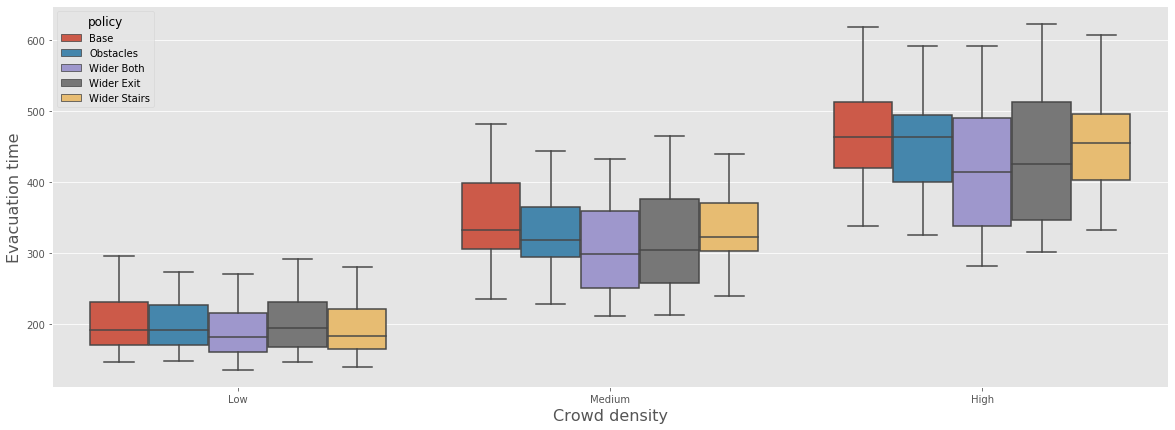

In [67]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(data=df_flow, x = "Density", y = "evac100", hue="policy")
plt.xlabel('Crowd density', fontsize=16)
plt.ylabel('Evacuation time', fontsize=16)
fig.savefig('overview-bottleneck-strategies-population-saved.jpg')

#### Familiarity ####

C:\Users\marce\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
C:\Users\marce\Anaconda3\lib\site-packages\pandas\io\formats\format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


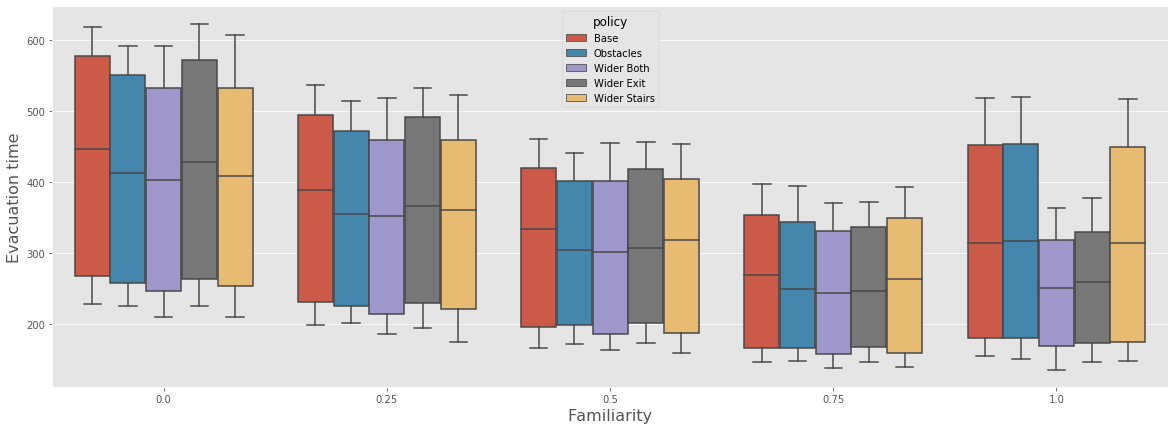

In [68]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(data=df_flow, x = "familiarity", y = "evac100", hue="policy")
plt.xlabel('Familiarity', fontsize=16)
plt.ylabel('Evacuation time', fontsize=16)
fig.savefig('overview-bottleneck-strategies-familiarity-saved.jpg')